In [10]:
# Hide deprecation warnings
import warnings
warnings.filterwarnings('ignore')

# Common imports
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MinMaxScaler
import pickle

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# To format floats
from IPython.display import display
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [11]:
#Load all the csv files into Pandas dataframes, properly parsing dates

df_train = pd.read_csv('../data/raw/train_values.csv',parse_dates=['date_recorded'])
df_test = pd.read_csv('../data/raw/test_values.csv',parse_dates=['date_recorded'])
df_labels = pd.read_csv('../data/raw/train_labels.csv')

#### Let's replace the construction year, longitude and latitude with the mean of the rest of the values.

In [12]:
class NumericalEnhancer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.num_list = []
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        self.num_list = ['latitude','longitude','construction_year']
        imputer = Imputer(strategy="median")

        num_cols = X[self.num_list]
        
        for num in num_cols:
            num_cols[num] = num_cols[num].replace([0,0.0],np.nan)
            
        imputer.fit(num_cols)
        Xnum = imputer.transform(num_cols)
        DF_num = pd.DataFrame(Xnum, columns=num_cols.columns, index = list(X.index.values))
        
        for col_name,col_content in DF_num.iteritems():
            X[col_name] = col_content
            
        return X

In [13]:
numEnhancer = NumericalEnhancer()
df_train = numEnhancer.fit_transform(df_train)
df_test = numEnhancer.transform(df_test)

#### Predict missing heights

In [14]:
def RMSLE(predicted, actual):
    msle = (np.log(predicted+1) - np.log(actual+1))**2
    rmsle = np.sqrt(msle.sum()/msle.count())
    return rmsle
    
def try_model(models, Xtrain, ytrain, Xtest, ytest):
    
    results_df = pd.DataFrame(columns=["Model", "RMSLE", "Mean Error", "Cross Val Mean Score"])
    
    for i, model in enumerate(models):
        model = model()
        model.fit(Xtrain, ytrain)
        y_model = model.predict(Xtest)
        xval_scores = np.sqrt(-cross_val_score(model, Xtrain, ytrain, scoring="neg_mean_squared_error", cv=10))
        results_df.loc[i,"Model"] = model
        results_df.loc[i,"RMSLE"] = RMSLE(y_model,ytest)
        results_df.loc[i,"Mean Error"] = np.sqrt(mean_squared_error(ytest, y_model))
        results_df.loc[i,"Cross Val Mean Score"] = xval_scores.mean()
    
    return results_df

Original heights

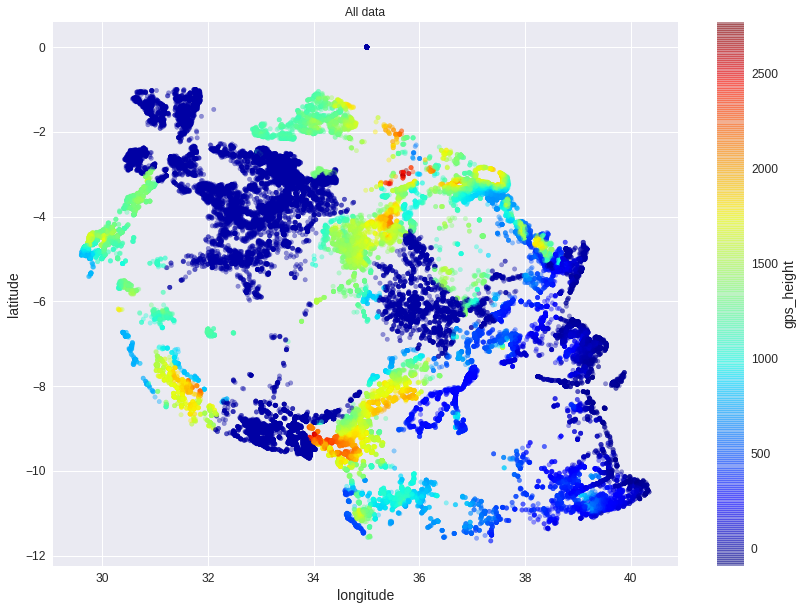

In [15]:
df_train.longitude = df_train.longitude.replace(np.nan, df_train.longitude.mean())
df_test.longitude = df_test.longitude.replace(np.nan, df_test.longitude.mean())

#Let's see the result of the predicted heights in the train dataframe
df_train[df_train.longitude > 0].plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    figsize=(14,10), title='All data',
    c="gps_height", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)

In [16]:
HeightTrain = df_train[['longitude','latitude','gps_height']][df_train.gps_height > 0]
HeightTest = df_train[['longitude','latitude','gps_height']][df_train.gps_height == 0]

Xtrain, Xtest, ytrain, ytest = train_test_split(HeightTrain[['longitude','latitude']], \
                                                HeightTrain['gps_height'], random_state=0)

models = [GaussianNB,LinearRegression,DecisionTreeRegressor,RandomForestRegressor]

height_results = try_model(models, Xtrain, ytrain, Xtest, ytest).sort_values(by=['Cross Val Mean Score'], \
                           ascending=[True]).reset_index(drop=True)
print(height_results)

                                               Model   RMSLE Mean Error  \
0  (DecisionTreeRegressor(criterion='mse', max_de... 0.14987   40.19844   
1  DecisionTreeRegressor(criterion='mse', max_dep... 0.17263   48.84963   
2                            GaussianNB(priors=None) 0.67566  447.29076   
3  LinearRegression(copy_X=True, fit_intercept=Tr... 0.94204  483.50736   

  Cross Val Mean Score  
0             41.85376  
1             51.43441  
2            408.73877  
3            487.51071  


In [17]:
pickle.dump(height_results.loc[0,"Model"], open('../models/height_model.sav', 'wb'))

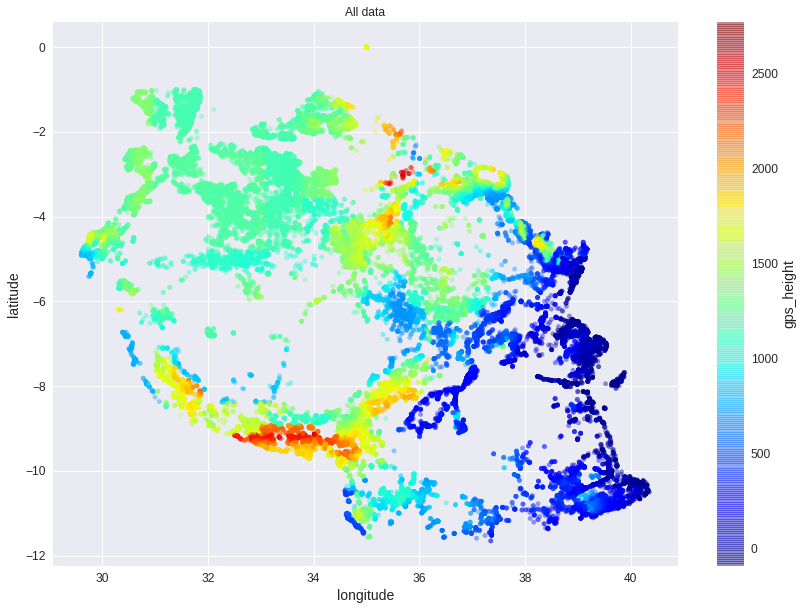

In [9]:
df_train['gps_height'][df_train.gps_height == 0] = height_results.loc[0,"Model"].\
predict(df_train[['longitude','latitude']][df_train.gps_height == 0])

df_test['gps_height'][df_test.gps_height == 0] = height_results.loc[0,"Model"].\
predict(df_test[['longitude','latitude']][df_test.gps_height == 0])

#Let's see the result of the predicted heights in the train dataframe
df_train[df_train.longitude > 0].plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    figsize=(14,10), title='All data',
    c="gps_height", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)

#### Drop features:

In [8]:
class DropFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, date_recorded = False):
        self.feature_list = ['id','wpt_name','region_code','recorded_by','payment_type',\
                         'quality_group','quantity_group','waterpoint_type_group']
        if date_recorded:
            self.feature_list.append('date_recorded')
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(self.feature_list, axis=1)

In [9]:
features_dropper = DropFeatures(date_recorded = True)
df_train = features_dropper.transform(df_train)
df_test = features_dropper.transform(df_test)

##### Reduce cardinality:

In [10]:
class ReduceCardinality(BaseEstimator, TransformerMixin):
    def __init__(self, date_recorded = False):
        self.col_dict  = {}
        
    def fit(self, X, y=None):
        for col in X.columns:
            if (X[col].dtype == np.object) and len(X[col].unique()) > 500:
                val_count = X[col].value_counts()
                val_count = val_count[val_count >20]
                self.col_dict[col] = val_count

        return self
    
    def transform(self, X):
        for col in X.columns:
            if col in self.col_dict:
                X[col] = X[col].map(lambda x: x if x in(self.col_dict[col]) else 'other')
        
        return X

In [11]:
cardReducer = ReduceCardinality()
df_train = cardReducer.fit_transform(df_train)
df_test = cardReducer.transform(df_test)

##### Vectorization
Let's create now the arrays that will be used in following tasks

In [12]:
class Vectorization(BaseEstimator, TransformerMixin):
    def __init__(self, date_recorded = False):
        self.lsNumericColumns  = []
        self.lsCategoricalColumns  = []
        self.vectorizer =  DictVectorizer(sparse=False)
        
    def fit(self, X, y=None):
        # process numeric and categorical variables separately
        for col in X.columns:
            if (X[col].dtype == np.object):
                self.lsCategoricalColumns.append(col)
            elif (X[col].dtype == np.int64) or (X[col].dtype == np.float64):
                self.lsNumericColumns.append(col)
        
        # categorical columns
        dfCateVariables = X.loc[:,self.lsCategoricalColumns]
        dfCateVariables.fillna('NA', inplace=True)
        vectorizer =  DictVectorizer(sparse=False)
        self.vectorizer.fit(dfCateVariables.T.to_dict().values())

        return self
    
    def transform(self, X):
        dfNumVariables = X.loc[:, self.lsNumericColumns]
        dfNumVariables.fillna(0, inplace=True)
        arrNumVariables = dfNumVariables.as_matrix()
        
        dfCateVariables = X.loc[:,self.lsCategoricalColumns]
        dfCateVariables.fillna('NA', inplace=True)
        arrCateFeatures = self.vectorizer.transform(dfCateVariables.T.to_dict().values())

        return np.concatenate((arrNumVariables,arrCateFeatures), axis=1)

In [13]:
vectorizator = Vectorization()
X_train = vectorizator.fit_transform(df_train)
X_test = vectorizator.transform(df_test)
y_train = df_labels.status_group.values

In [14]:
X_train.shape

(59400, 2389)

In [15]:
X_test.shape

(14850, 2389)

In [16]:
y_train.shape

(59400,)

#### Standarization

In [17]:
# Normalization of the numerical features
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

#### PCA

Although the dataset has many features, let's try to visualize in 2D the different groups using PCA.

In [18]:
pca = PCA(n_components=2)
X_train_viz = pca.fit_transform(X_train)

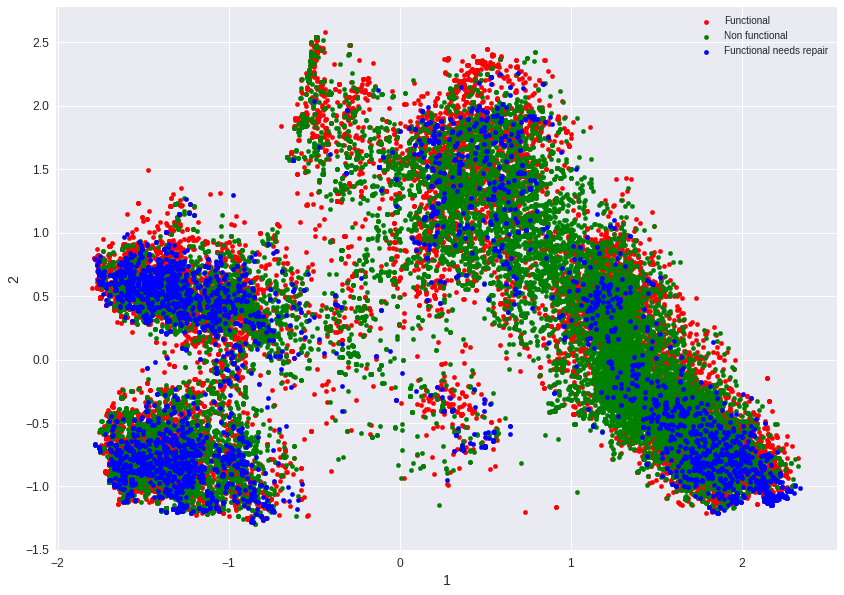

In [19]:
df_PCA = pd.DataFrame(X_train_viz, columns=[1, 2])
df_PCA['label'] = y_train

ax = df_PCA[df_PCA.label=='functional'].plot(kind='scatter', x=1, y=2, color='r', 
                                             label='Functional', figsize=(14,10))
df_PCA[df_PCA.label=='non functional'].plot(kind='scatter', x=1, y=2, color='g', 
                                            label='Non functional', ax=ax)
df_PCA[df_PCA.label=='functional needs repair'].plot(kind='scatter', x=1, y=2, color='b', 
                                               label='Functional needs repair', ax=ax);

There is no obvious separation between groups with only 2 dimensions. Let's see how many do we need in order to loose the minimum possible variance.

In [20]:
pca = PCA(n_components=100)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

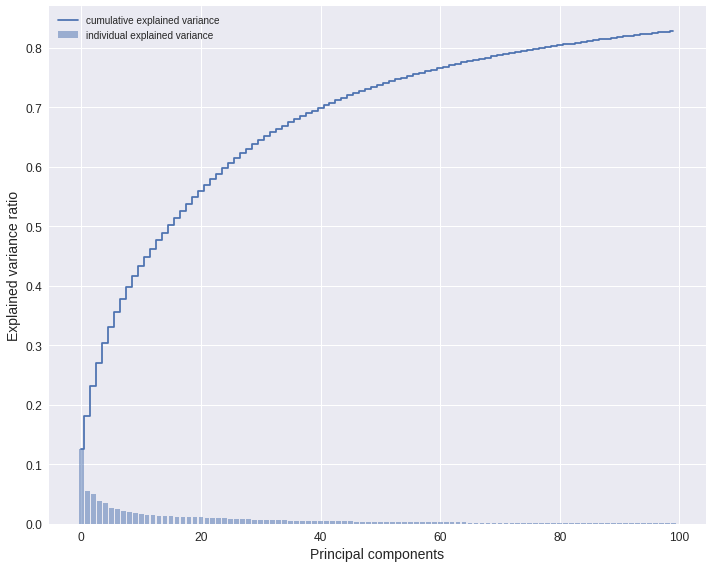

In [21]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
var_exp = pca.explained_variance_ratio_

plt.figure(figsize=(10, 8))
plt.bar(range(100), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(100), cumsum, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()

Working with the PCA reduced data:

56.8 s ± 441 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
CV accuracy: 0.772 +/- 0.006


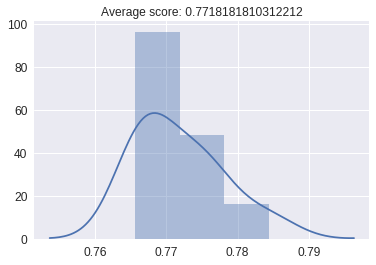

In [22]:
%timeit -n 1 -r 3 cv_scores = cross_val_score(RandomForestClassifier(), X_train_reduced, y_train, cv=10)
cv_scores = cross_val_score(RandomForestClassifier(), X_train_reduced, y_train, cv=10)
sns.distplot(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))

Working with all the features after reducing cardinality:

1min 4s ± 1.22 s per loop (mean ± std. dev. of 3 runs, 1 loop each)
CV accuracy: 0.796 +/- 0.007


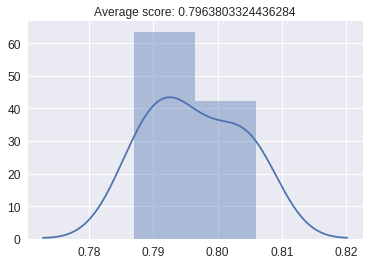

In [23]:
%timeit -n 1 -r 3 cv_scores = cross_val_score(RandomForestClassifier(), X_train, y_train, cv=10)
cv_scores = cross_val_score(RandomForestClassifier(), X_train, y_train, cv=10)
sns.distplot(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))

We can see that with PCA, the accuracy drops around 2%, but the model deals with less than 5% features.

#### Let's save these matrices to work with them in the modelling section

In [24]:
np.savetxt("../data/processed/X_train.csv", X_train_reduced, delimiter=",")
np.savetxt("../data/processed/X_test.csv", X_test_reduced, delimiter=",")